## This is a repeat assignment. I have used the pytreebank package last time to get the SST dataset. Here we will create the dataset on our own.

In [3]:
!pip install google_trans_new

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext.legacy
from torchtext import datasets

import re
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import spacy
import nltk
from nltk.corpus import stopwords, wordnet
nltk.download('wordnet')
nltk.download('stopwords')

import pytreebank

import google_trans_new 
from google_trans_new import google_translator  
import random

import os, pickle

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Get Dataset

In [28]:
# if issue in calling above fuction to get the dataset
# dataset = pickle.load( open( "/content/session5/dataset.pkl", "rb" ) )

In [6]:
data_train = [example.to_labeled_lines()[0] for example in dataset["train"]]
data_test = [example.to_labeled_lines()[0] for example in dataset["test"]]

In [7]:
len(data_train), len(data_test)

(8544, 2210)

In [8]:
train = pd.DataFrame(data_train, columns = ['label', 'sentence'])
test = pd.DataFrame(data_test, columns = ['label', 'sentence'])

In [9]:
train.head()

,label,sentence
0,3,The Rock is destined to be the 21st Century 's...
1,4,The gorgeously elaborate continuation of `` Th...
2,3,Singer/composer Bryan Adams contributes a slew...
3,2,You 'd think by now America would have had eno...
4,3,Yet the act is still charming here .


In [10]:
train['label'].value_counts()

3    2322
1    2218
2    1624
4    1288
0    1092
Name: label, dtype: int64

[Text(0.5, 0, 'Labels')]

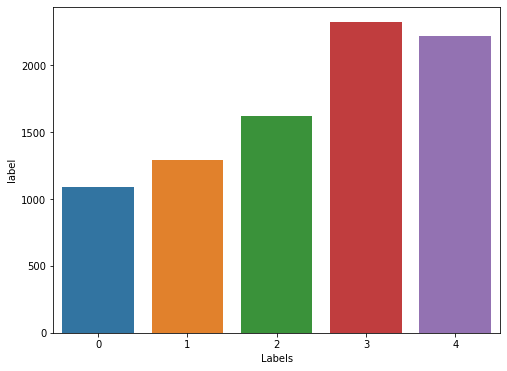

In [11]:
fig = plt.figure(figsize=(8,6))

ax = sns.barplot(x=train['label'].unique(), y=train['label'].value_counts())

ax.set(xlabel = 'Labels')

### Data seems to be imbalanced. We will try to make it balanced

## Augment Data

### Back Translation

In [12]:
def back_translate(sentence):
  """ Google translate the input sentence and translate back"""
  available_langs = list(google_trans_new.LANGUAGES.keys()) 
  trans_lang = random.choice(available_langs) 
  translator = google_translator()  
  translate_text = translator.translate(sentence,lang_tgt=trans_lang) 
  translate_back = translator.translate(translate_text,lang_tgt='en')

  return (translate_back)

In [13]:
# test function 
sentence = ' Pulling out the classic Amazon Mechanical Turk workers, \
the authors presented these phrases in a random order and asked annotators to indicate the sentiment and degree of sentiment for each phrase using a slider.'
test_bt = back_translate(sentence)
test_bt

'Pull out the Classic Amazon Mechanical Turk workers, the authors present these sentences in a random order and ask the annotates to indicate the feeling and degree of feelings for each sentence using a cursor. '

### Random Deletion
As the name suggests, random deletion deletes words from a sentence. Given a probability parameter p, it will go through the sentence and decide whether to delete a word or not based on that random probability. Consider of it as pixel dropouts while treating images.

In [14]:
def random_deletion(sentence, p=0.5): 
    words = sentence.split()
    if len(words) == 1: # return if single word
        return words
    remaining = list(filter(lambda x: random.uniform(0,1) > p,words)) 
    if len(remaining) == 0: # if not left, sample a random word
        return [random.choice(words)] 
    else:
        return (' '.join(remaining))

In [15]:
test_rd = random_deletion(sentence, p=0.5)
test_rd

'the classic Amazon Mechanical the authors phrases a random order and asked annotators sentiment and degree for'

### Random Swap
The random swap augmentation takes a sentence and then swaps words within it n times, with each iteration working on the previously swapped sentence. Here we sample two random numbers based on the length of the sentence, and then just keep swapping until we hit n.



In [16]:
def random_swap(sentence, n=5): 
    words = sentence.split()
    if len(words) == 1: # return if single word
        return words
    length = range(len(words)) 
    for _ in range(n):
        idx1, idx2 = random.sample(length, 2)
        words[idx1], words[idx2] = words[idx2], words[idx1] 
    return (' '.join(words))

In [17]:
test_rs = random_swap(sentence, n=5)
test_rs

'Pulling out the classic Amazon phrases Turk workers, the authors slider. these Mechanical in a random indicate and asked annotators of the order sentiment and degree to sentiment for each phrase using a presented'

## Random Insertion
A random insertion technique looks at a sentence and then randomly inserts synonyms of existing non-stopwords into the sentence n times. Assuming you have a way of getting a synonym of a word and a way of eliminating stopwords (common words such as and, it, the, etc.)


In [18]:
stop_words = set(stopwords.words('english'))

def random_insertion(sentence, n=4): 
    words = sentence.split()
    if len(words) == 1: # return if single word
        return words
    words = [w for w in words if not w.lower() in stop_words]
    for _ in range(n):
        word = random.choice(words)
        synonym = wordnet.synsets(word)
        if len(synonym) > 0:
          sentence.replace(word, synonym[0].lemmas()[0].name())
    return sentence

In [19]:
test_ri = random_insertion(sentence, n=3)
test_ri

' Pulling out the classic Amazon Mechanical Turk workers, the authors presented these phrases in a random order and asked annotators to indicate the sentiment and degree of sentiment for each phrase using a slider.'

## Generate Augmented Data

In [20]:
# Get the less populated classes
df_class_0 = train[train['label'] == 0]  # 1092
df_class_4 = train[train['label'] == 4]  # 1288 
df_class_2 = train[train['label'] == 2]  # 1624
df_class_1 = train[train['label'] == 1]  # 2218 
df_class_3 = train[train['label'] == 3]  # 2322

## Get the data balanced

In [21]:
# Populate class 0

# Random Deletion
df_class_0_rd = df_class_0.sample(frac=.75)
df_class_0_rd['sentence'] = df_class_0_rd['sentence'].apply(lambda x: random_deletion(x))

# Random Swap
df_class_0_rs = df_class_0.sample(frac=.75)
df_class_0_rs['sentence'] = df_class_0_rs['sentence'].apply(lambda x: random_swap(x))

# Random Insert
df_class_0_ri = df_class_0.sample(frac=.75)
df_class_0_ri['sentence'] = df_class_0_ri['sentence'].apply(lambda x: random_insertion(x))

# Populate class 4

# Random Deletion
df_class_4_rd = df_class_4.sample(frac=.60)
df_class_4_rd['sentence'] = df_class_4_rd['sentence'].apply(lambda x: random_deletion(x))

# Random Swap
df_class_4_rs = df_class_4.sample(frac=.60)
df_class_4_rs['sentence'] = df_class_4_rs['sentence'].apply(lambda x: random_swap(x))

# Random Insert
df_class_4_ri = df_class_4.sample(frac=.60)
df_class_4_ri['sentence'] = df_class_4_ri['sentence'].apply(lambda x: random_insertion(x))

# Populate class 2

# Random Deletion
df_class_2_rd = df_class_2.sample(frac=.33)
df_class_2_rd['sentence'] = df_class_2_rd['sentence'].apply(lambda x: random_deletion(x))

# Random Swap
df_class_2_rs = df_class_2.sample(frac=.33)
df_class_2_rs['sentence'] = df_class_2_rs['sentence'].apply(lambda x: random_swap(x))

# Random Insert
df_class_2_ri = df_class_2.sample(frac=.33)
df_class_2_ri['sentence'] = df_class_2_ri['sentence'].apply(lambda x: random_insertion(x))

# Populate class 1

# Random Deletion
df_class_1_rd = df_class_1.sample(frac=.16)
df_class_1_rd['sentence'] = df_class_1_rd['sentence'].apply(lambda x: random_deletion(x))

# Random Swap
df_class_1_rs = df_class_1.sample(frac=.16)
df_class_1_rs['sentence'] = df_class_1_rs['sentence'].apply(lambda x: random_swap(x))

# Random Insert
df_class_1_ri = df_class_1.sample(frac=.16)
df_class_1_ri['sentence'] = df_class_1_ri['sentence'].apply(lambda x: random_insertion(x))

# Populate class 3

# Random Deletion
df_class_3_rd = df_class_3.sample(frac=.16)
df_class_3_rd['sentence'] = df_class_3_rd['sentence'].apply(lambda x: random_deletion(x))

# Random Swap
df_class_3_rs = df_class_3.sample(frac=.16)
df_class_3_rs['sentence'] = df_class_3_rs['sentence'].apply(lambda x: random_swap(x))

# Random Insert
df_class_3_ri = df_class_3.sample(frac=.16)
df_class_3_ri['sentence'] = df_class_3_ri['sentence'].apply(lambda x: random_insertion(x))

In [22]:
# Concatenate the records for creating balanced dataset
train_interim = pd.concat([train, df_class_0_rd, df_class_2_rd, df_class_4_rd, df_class_1_rd, df_class_3_rd,  \
                           df_class_0_rs, df_class_2_rs, df_class_4_rs, df_class_1_rs, df_class_3_rs,  \
                           df_class_0_ri, df_class_2_ri , df_class_4_ri, df_class_1_ri, df_class_3_ri], ignore_index=True)

In [23]:
train_interim['label'].value_counts()

4    3607
0    3549
3    3438
1    3283
2    3232
Name: label, dtype: int64

In [24]:
# Back Translate
df_part_bt = train.sample( n=5)
df_part_bt['sentence'] = df_part_bt['sentence'].apply(lambda x: back_translate(x))
df_part_bt.head()

,label,sentence
2166,4,"What I saw , I enjoyed ."
3354,4,A movie that begins with the daily life of nav...
6924,1,"The Good-Nature Comby Ensemble, which is tryin..."
5113,1,"Ignoring this, did Swimfan anyway"
5217,1,The Dilîrê Tîrete Story of Shreve is on the sc...


In [25]:
# train_final = pd.concat([train_interim], ignore_index=True)
train_final = pd.concat([df_part_bt, train_interim], ignore_index=True)

In [26]:
train_final.shape

(17114, 2)

In [27]:
train_final.head()

,label,sentence
0,4,"What I saw , I enjoyed ."
1,4,A movie that begins with the daily life of nav...
2,1,"The Good-Nature Comby Ensemble, which is tryin..."
3,1,"Ignoring this, did Swimfan anyway"
4,1,The Dilîrê Tîrete Story of Shreve is on the sc...


In [28]:
train_final['label'].value_counts()

4    3609
0    3549
3    3438
1    3286
2    3232
Name: label, dtype: int64

### Serialize the dataframe 

In [ ]:
with open('train_final.pkl', 'wb') as train_set: 
    pickle.dump(train_final, train_set)

[Text(0.5, 0, 'Labels')]

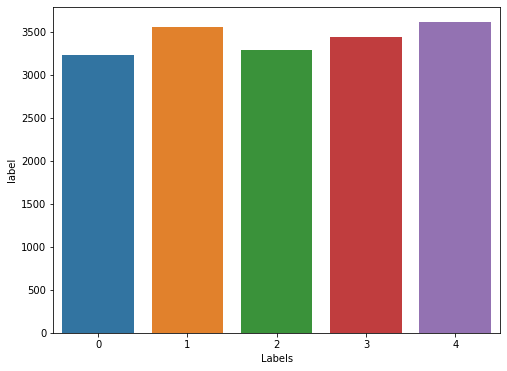

In [29]:
fig = plt.figure(figsize=(8,6))

ax = sns.barplot(x=train_final['label'].unique(), y=train_final['label'].value_counts())

ax.set(xlabel = 'Labels')

### We have got nearly balanced

### Tokenize the data

In [30]:
train_final.to_csv('train_final.csv', index=False)
test.to_csv('test.csv', index=False)

In [31]:
def text_clean(text):
  text = re.sub(r'[^A-Za-z0-9_-]+', ' ', text)
  text = re.sub(r'https?:/\/\S+', ' ', text)

  return(text.strip())

In [32]:
nlp = spacy.load('en', disable = ['parser', 'tagger', 'ner'])
def tokenizer(s):
  return [w.text.lower() for w in nlp(text_clean(s))]

In [33]:
TEXT = torchtext.legacy.data.Field(tokenize = tokenizer)

LABEL = torchtext.legacy.data.LabelField(dtype = torch.float)

In [34]:
datafields = [('label', LABEL), ('sentence', TEXT)]

In [35]:
trn, tst = torchtext.legacy.data.TabularDataset.splits(path='/content/session5',
                                                       train = 'train_final.csv',
                                                       test = 'test.csv',
                                                       format = 'csv',
                                                       skip_header = True,
                                                       fields = datafields
                                                       )

In [36]:
trn[:5]

In [37]:
print(f'Number of examples in training {len(trn)}')
print(f'Number of examples in test {len(tst)}')

Number of examples in training 17114
Number of examples in test 2210


In [38]:
trn[5].__dict__.keys()

dict_keys(['label', 'sentence'])

In [40]:
print(vars(trn[5]))

{'label': '3', 'sentence': ['the', 'rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'century', 's', 'new', 'conan', 'and', 'that', 'he', 's', 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'arnold', 'schwarzenegger', 'jean', '-', 'claud', 'van', 'damme', 'or', 'steven', 'segal']}


In [41]:
words = [0 + len(t.sentence) for t in trn]

In [42]:
sum(words)

275634

In [43]:
TEXT.build_vocab(trn, max_size = 18000,
                 vectors = "glove.6B.100d",
                 unk_init = torch.Tensor.normal_ )

LABEL.build_vocab(trn) 

.vector_cache/glove.6B.zip: 862MB [02:40, 5.36MB/s]                           
 99%|█████████▉| 397445/400000 [00:14<00:00, 25950.49it/s]

### Serialize Vocab

In [44]:
with open('TEXT.pkl', 'wb') as text: 
    pickle.dump(TEXT, text)

In [45]:
with open('LABEL.pkl', 'wb') as label: 
    pickle.dump(LABEL, label)

 99%|█████████▉| 397445/400000 [00:29<00:00, 25950.49it/s]

In [46]:
print(TEXT.vocab.freqs.most_common(50))

[('the', 13374), ('a', 9714), ('and', 8373), ('of', 8218), ('to', 5496), ('-', 5066), ('is', 4688), ('s', 4608), ('it', 4367), ('that', 3593), ('in', 3480), ('as', 2329), ('film', 2081), ('with', 2043), ('movie', 1969), ('but', 1969), ('for', 1869), ('this', 1867), ('an', 1748), ('its', 1721), ('you', 1561), ('t', 1240), ('be', 1233), ('n', 1224), ('on', 1220), ('one', 1098), ('not', 1056), ('by', 992), ('about', 975), ('--', 949), ('has', 944), ('more', 930), ('all', 917), ('are', 910), ('like', 904), ('from', 899), ('at', 898), ('than', 869), ('have', 838), ('his', 812), ('i', 802), ('so', 788), ('if', 706), ('or', 703), ('story', 649), ('out', 624), ('what', 610), ('who', 590), ('too', 584), ('there', 567)]


In [47]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'the', 'a', 'and', 'of', 'to', '-', 'is', 's']


In [48]:
print(LABEL.vocab.stoi)

defaultdict(None, {'4': 0, '0': 1, '3': 2, '1': 3, '2': 4})


In [49]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, test_iterator = torchtext.legacy.data.BucketIterator.splits(
                                                                            (trn, tst),
                                                                            batch_size = BATCH_SIZE,
                                                                            sort_key = lambda x: len(x.sentence),
                                                                            sort_within_batch= True, 
                                                                            device = device)

In [145]:
class RNN(nn.Module):
  
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
    
    super().__init__()

    self.embedding = nn.Embedding(vocab_size, embedding_dim)

    self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers = n_layers,
                      bidirectional = bidirectional, dropout = dropout )
    
    self.fc = nn.Linear(hidden_dim*2, output_dim)

    self.dropout = nn.Dropout(dropout)

  def forward(self, text):

    embedded =  self.dropout(self.embedding(text))

    output, hidden = self.rnn(embedded)

    hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))

    return self.fc(hidden.squeeze(0))

In [146]:
input_dim = len(TEXT.vocab)

embedding_dim = 100

hidden_dim  = 256

output_dim = 5

num_layers = 2

bidirectional = True

dropout = .3

In [147]:
model = RNN(input_dim, 
            embedding_dim,
            hidden_dim,
            output_dim,
            num_layers,
            bidirectional,
            dropout)

In [148]:
model

RNN(
  (embedding): Embedding(15365, 100)
  (rnn): GRU(100, 256, num_layers=2, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=512, out_features=5, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [149]:
pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)

torch.Size([15365, 100])


In [150]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.9054,  1.0998, -0.6870,  ...,  0.4289, -0.9859, -0.2622],
        [ 0.3003,  0.2284,  0.3942,  ...,  0.1733,  1.0656,  0.3687],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.0515, -0.3798, -0.5699,  ..., -0.0349,  0.3298,  1.1395],
        [ 0.5719, -0.7835,  0.4352,  ..., -0.2164, -0.7241,  0.2962],
        [ 0.2512,  0.6499, -0.2465,  ...,  0.0659, -0.9114,  0.4129]])

In [151]:
unk_idx = TEXT.vocab.stoi[TEXT.unk_token]
pad_idx = TEXT.vocab.stoi[TEXT.pad_token]

model.embedding.weight.data[unk_idx] = torch.zeros(embedding_dim)
model.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.0515, -0.3798, -0.5699,  ..., -0.0349,  0.3298,  1.1395],
        [ 0.5719, -0.7835,  0.4352,  ..., -0.2164, -0.7241,  0.2962],
        [ 0.2512,  0.6499, -0.2465,  ...,  0.0659, -0.9114,  0.4129]])


In [152]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 3,271,673 trainable parameters


In [153]:
optimizer = optim.Adam(model.parameters(), lr = 1e-5)
criterion = nn.CrossEntropyLoss()

In [154]:
# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [155]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
               
        # convert to 1D tensor
        predictions = model(batch.sentence).squeeze(1)
        
        # compute the loss
        loss = criterion(predictions, batch.label.long())        
        
        # compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label.long())   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [156]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
                   
            # convert to 1d tensor
            predictions = model(batch.sentence).squeeze(1)
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.label.long())
            acc = binary_accuracy(predictions, batch.label.long())
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [157]:
N_EPOCHS = 100

best_test_loss = float('inf')

trn_loss = [] 
trn_acc = []
tst_loss = [] 
tst_acc = [] 

for epoch in range(N_EPOCHS):

    if epoch > 80:
      optimizer = optim.Adam(model.parameters(), lr = 1e-4)
     
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    trn_loss.append(train_loss)
    trn_acc.append(train_acc*100)
    
    # evaluate the model
    test_loss, test_acc = evaluate(model, test_iterator, criterion)
    tst_loss.append(test_loss)
    tst_acc.append(test_acc*100)
    
    # # save the best model
    # if test_loss < best_test_loss:
    #     best_test_loss = test_loss
    #     torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'Epoch: {epoch+1}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {test_loss:.3f} |  Val. Acc: {test_acc*100:.2f}% \n')

Epoch: 1
	Train Loss: 1.608 | Train Acc: 21.31%
	 Val. Loss: 1.608 |  Val. Acc: 22.71% 

Epoch: 2
	Train Loss: 1.600 | Train Acc: 25.64%
	 Val. Loss: 1.603 |  Val. Acc: 23.22% 

Epoch: 3
	Train Loss: 1.592 | Train Acc: 27.79%
	 Val. Loss: 1.594 |  Val. Acc: 25.44% 

Epoch: 4
	Train Loss: 1.584 | Train Acc: 29.17%
	 Val. Loss: 1.587 |  Val. Acc: 25.10% 

Epoch: 5
	Train Loss: 1.573 | Train Acc: 29.80%
	 Val. Loss: 1.574 |  Val. Acc: 26.88% 

Epoch: 6
	Train Loss: 1.560 | Train Acc: 30.97%
	 Val. Loss: 1.561 |  Val. Acc: 26.84% 

Epoch: 7
	Train Loss: 1.541 | Train Acc: 31.63%
	 Val. Loss: 1.539 |  Val. Acc: 27.30% 

Epoch: 8
	Train Loss: 1.516 | Train Acc: 32.74%
	 Val. Loss: 1.512 |  Val. Acc: 26.65% 

Epoch: 9
	Train Loss: 1.492 | Train Acc: 33.13%
	 Val. Loss: 1.485 |  Val. Acc: 27.50% 

Epoch: 10
	Train Loss: 1.472 | Train Acc: 34.20%
	 Val. Loss: 1.470 |  Val. Acc: 27.11% 

Epoch: 11
	Train Loss: 1.454 | Train Acc: 35.38%
	 Val. Loss: 1.448 |  Val. Acc: 29.44% 

Epoch: 12
	Train Lo

## Train test logs

Text(0.5, 1.0, 'Accuracy')

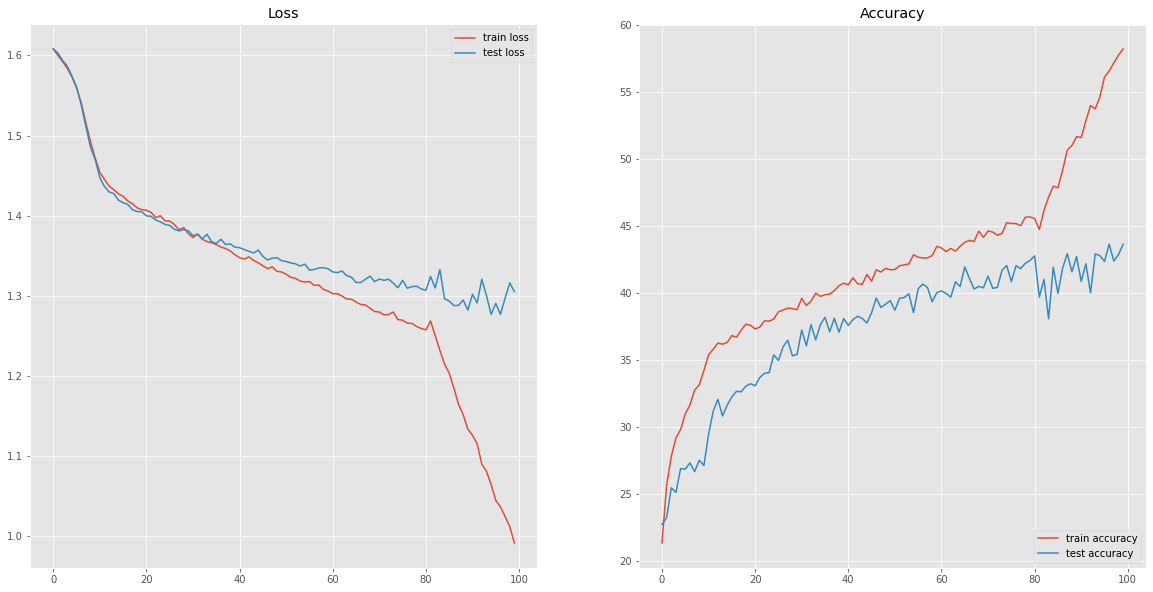

In [158]:
plt.style.use('ggplot')

fig, axs = plt.subplots(1,2,figsize=(20,10))

axs[0].plot(trn_loss, label = 'train loss')
axs[0].plot(tst_loss, label = 'test loss')
axs[0].legend(loc="upper right")
axs[0].set_title("Loss")

axs[1].plot(trn_acc,  label = 'train accuracy')
axs[1].plot(tst_acc,  label = 'test accuracy')
axs[1].legend(loc="lower right")
axs[1].set_title("Accuracy")

## Validate model results

In [86]:
def test_model(sentence):
  tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
  indexed = [TEXT.vocab.stoi[t] for t in tokenized]
  tensor = torch.LongTensor(indexed)
  tensor = tensor.unsqueeze(1).to(device)

  model.eval()
  prediction = model(tensor)

  return( ["very negative", "negative", "neutral", "positive", "very positive"][torch.argmax(prediction, dim=0).item()] )

In [87]:
sentence = 'That movie was really very bad'
test_model(sentence)

'negative'

In [108]:
sentence = 'That match between teams was great'
test_model(sentence)

'very negative'

In [92]:
sentence = 'I am liking END course'
test_model(sentence)

'very positive'

In [93]:
sentence = 'Covid is all over'
test_model(sentence)

'negative'

In [94]:
sentence = 'That movie was really pathetic'
test_model(sentence)

'negative'

## Validate results on test data

In [111]:
sentence = test.sentence[111]
label = test.label[111]
test_model(sentence), ["very negative", "negative", "neutral", "positive", "very positive"][label], sentence

('neutral',
 'neutral',
 "Hip-hop has a history , and it 's a metaphor for this love story .")

In [106]:
sentence = test.sentence[403]
label = test.label[403]
test_model(sentence), ["very negative", "negative", "neutral", "positive", "very positive"][label], sentence

('very negative',
 'very positive',
 "The best movie of its kind since ` Brazil . '")

In [117]:
sentence = test.sentence[906]
label = test.label[906]
test_model(sentence), ["very negative", "negative", "neutral", "positive", "very positive"][label], sentence

('very negative',
 'neutral',
 'The actors are so terrific at conveying their young angst , we do indeed feel for them .')

In [159]:
sentence = test.sentence[2000]
label = test.label[2000]
test_model(sentence), ["very negative", "negative", "neutral", "positive", "very positive"][label], sentence

('negative',
 'very negative',
 'Even by dumb action-movie standards , Ballistic : Ecks vs. Sever is a dumb action movie .')

In [160]:
sentence = test.sentence[2001]
label = test.label[2001]
test_model(sentence), ["very negative", "negative", "neutral", "positive", "very positive"][label], sentence

('negative',
 'negative',
 'The film equivalent of a toy chest whose contents get scattered over the course of 80 minutes .')